# TrES-5 b Occultation Tests

**NOTE:** Some 'problem' data points that are removed:


|  i  | epoch |  y  | data point from csv |
| --- |  ---  | --- |         ---         |
| 14  | 974   | -4884.850160682981 | (-1655,2456596.38431,0.00065,0.00065,56.16,56.16,2022ApJS..259...62I; 2018MNRAS.480..291S)|
|55| 1588| -776.1948236497119| (-1041,2457506.531309184,0.00048,0.00048,41.47,41.47,TRESCA)|
|195| 3165| -1018.7907784507843| (537,2459845.513720722,0.00053,0.00053,45.79,45.79,TRESCA)|

## Imports

### Importing packages and libraries

In [1]:
%pip install susie==1.2.1 -q


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard Python Packages
import time
import random
import datetime as dt
import matplotlib.pyplot as plt
# Numerical Packages
import numpy as np
import pandas as pd
# Susie
from susie.timing_data import TimingData
from susie.ephemeris import Ephemeris
# Astropy/plan
from astropy.time import Time
import astropy.coordinates as coord
import astropy.units as u
from astroplan import FixedTarget, Observer, EclipsingSystem
from astroplan import (is_event_observable, AtNightConstraint, AltitudeConstraint, LocalTimeConstraint)
# Helper functions
# from helpers import find_oc_outliers, convert_to_tdb, get_epochs_for_new_data, get_n_random_observations

### Helper Functions

In [3]:
def find_oc_outliers(ephemeris_obj, y_limit, return_type='str'):
    # Used in O-C plotting to calculate scatter points
    DAYS_TO_SECONDS = 86400
    lin_model = ephemeris_obj.get_model_ephemeris('linear')
    y = (ephemeris_obj._subtract_plotting_parameters(ephemeris_obj.timing_data.mid_times, lin_model['conjunction_time'], lin_model['period'], ephemeris_obj.timing_data.epochs)) * DAYS_TO_SECONDS
    outliers = []
    outliers_str = []
    i = 0
    while i in range(len(y)):
        # if epochs[i] > 3000 and epochs[i] < 4000:
        if y[i] < y_limit:
            outliers.append([i, ephemeris_obj.timing_data.epochs[i], y[i], ephemeris_obj.timing_data.mid_times[i]])
            outliers_str.append(f"index: {i}, epoch: {ephemeris_obj.timing_data.epochs[i]}, y value: {y[i]}, mid-time: {ephemeris_obj.timing_data.mid_times[i]}")
        i+=1
    if return_type == 'str':
        return outliers_str
    elif return_type == 'numerical':
        return outliers
    
def convert_to_tdb(skycoord_obj, location_obj, time_obj):
    """
    time_obj:
        Astropy time object, must have time format of JD, can be any time scale.
    """
    # Set location for time object
    time_obj.location = location_obj
    # Calc barycentric light travel time
    ltt_bary = time_obj.light_travel_time(skycoord_obj)
    # Add light travel time and set scale to TDB
    times_bjd = time_obj.tdb + ltt_bary
    return times_bjd

def get_epochs_for_new_data(T, T0, P, tra_or_occ):
    N = (T-T0)/P
    if tra_or_occ == "occ":
        N = np.floor(N)
    return int(N)
    
def str_time_prop(start, end, time_format, prop):
    """Get a time at a proportion of a range of two formatted times.

    start and end should be strings specifying times formatted in the
    given format (strftime-style), giving an interval [start, end].
    prop specifies how a proportion of the interval to be taken after
    start.  The returned time will be in the specified format.
    """

    stime = time.mktime(time.strptime(start, time_format))
    etime = time.mktime(time.strptime(end, time_format))

    ptime = stime + prop * (etime - stime)

    return time.strftime(time_format, time.localtime(ptime))


def random_date(start, end, prop):
    return str_time_prop(start, end, '%Y-%m-%d %H:%M', prop)

def get_n_random_observations(n, tra_or_occ, start_time, end_time, astroplan_target, skycoord_obj, earthlocation_obj, conjunction_time, orb_period):
    random.seed(1) # Set seed so we get the same random dates (this ensures reproducibility)
    # Get n random dates
    random_dates = []
    for i in range(n):
        random_dates.append(random_date(start_time, end_time, random.random()))
    # Get next occultation for each date
    new_mid_times = []
    for date in random_dates:
        if tra_or_occ == "tra":
            new_mid_times.append(astroplan_target.next_primary_eclipse_time(Time(date), n_eclipses=1)[0])
        elif tra_or_occ == "occ":
            new_mid_times.append(astroplan_target.next_secondary_eclipse_time(Time(date), n_eclipses=1)[0])
    # Convert list to one Time object and convert to JD format
    new_mid_times = Time(new_mid_times)
    new_mid_times.format = "jd"
    # Convert each occultation into BJD TDB
    new_mid_times_bjd = convert_to_tdb(skycoord_obj, earthlocation_obj, new_mid_times)
    # Get epoch for each time
    new_epochs = []
    for time in new_mid_times_bjd:
        new_epochs.append(get_epochs_for_new_data(np.array([time.value]), conjunction_time, orb_period, tra_or_occ))
    new_errs = np.full(n, 0.001)
    new_tra_or_occ = np.full(n, "occ")
    return_dict = {
        "new_epochs": new_epochs,
        "new_mid_times": new_mid_times, 
        "new_mid_time_errs": new_errs, 
        "new_tra_or_occ": new_tra_or_occ
    }
    return return_dict

### Importing Data

In [4]:
# url = "all_lit_times_TrES-5b.csv"
url = "data/combined_times_TrES-5b.csv"

# Read the CSV file directly from the URL
data = pd.read_csv(url)
epochs = np.array(data["Epoch"].astype('int'))
mid_times = np.array(data["Midtime"])
mid_time_errs = np.array(data["Midtime_err_minus_days"])
tra_or_occ = np.array(['tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra', 'tra'])

In [5]:
og_epochs = epochs.copy()
og_mid_times = mid_times.copy()
og_mid_time_errs = mid_time_errs.copy()
og_tra_or_occ = tra_or_occ.copy()

## Basic Susie Usage & Plots

### Creating timing and ephemeris objects

In [6]:
# Create new transit times object with above data
timing_obj1 = TimingData('jd', epochs, mid_times, mid_time_uncertainties=mid_time_errs, time_scale='tdb')
ephemeris_obj1 = Ephemeris(timing_obj1)

In [7]:
# Getting a linear model will solve for period and conjuction time (and their respective errors)
linear_model_data = ephemeris_obj1.get_model_ephemeris('linear')

In [8]:
# Getting a quadratic model will solve for period, conjuction time, and period change per epoch (and their respective errors)
quadratic_model_data = ephemeris_obj1.get_model_ephemeris('quadratic')

### Plotting some things

O-C Plot

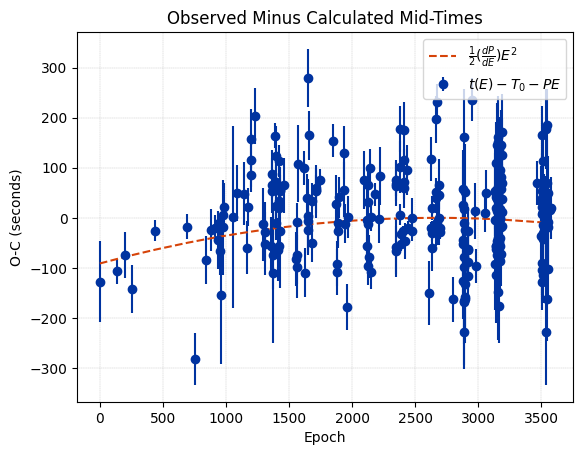

In [9]:
ephemeris_obj1.plot_oc_plot()

**NOTE:** Finding O-C outliers (already processed, 3 data points removed, see top of notebook)

In [10]:
find_oc_outliers(ephemeris_obj1, -250)

['index: 6, epoch: 754, y value: -281.1606324168679, mid-time: 2456270.3438575845']

Model Uncertainties

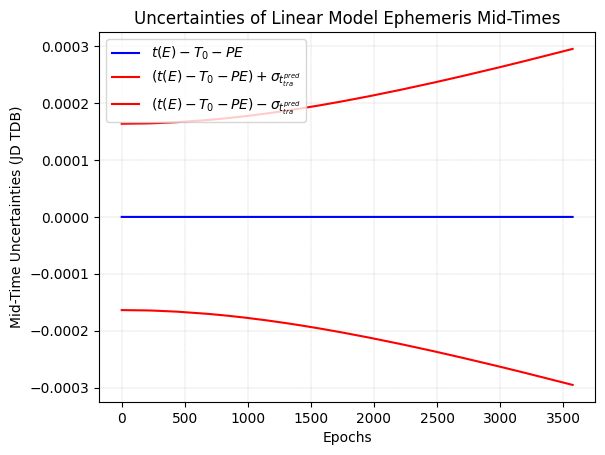

In [11]:
ephemeris_obj1.plot_timing_uncertainties(linear_model_data, save_plot=False)

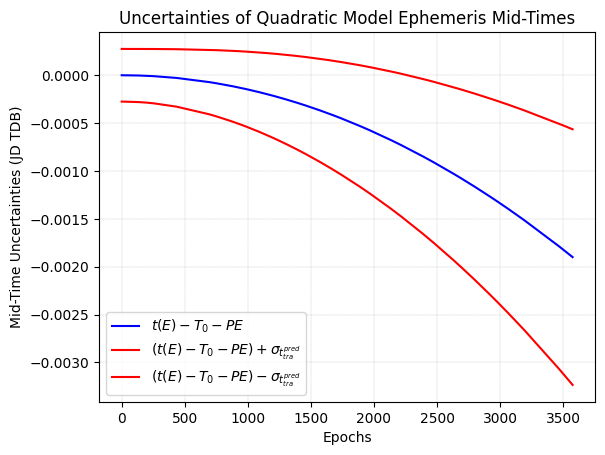

In [12]:
ephemeris_obj1.plot_timing_uncertainties(quadratic_model_data, save_plot=False)

Running Delta BIC Plot

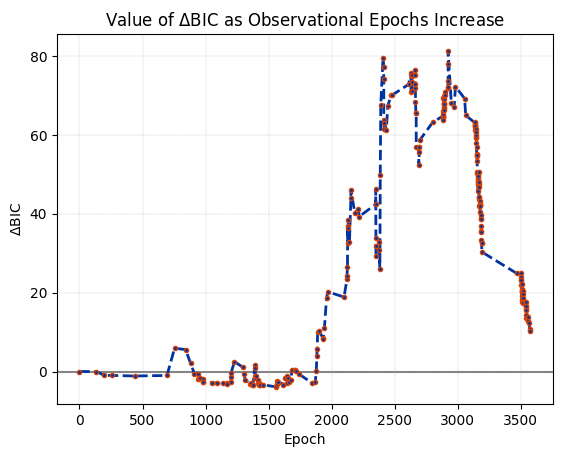

In [13]:
ephemeris_obj1.plot_running_delta_bic()

In [14]:
ephemeris_obj1.calc_delta_bic()

np.float64(10.331706633168551)

## Astroplan (Getting the occultation times)

### Creating the astroplan EclipsingSystem object

In [15]:
# From Boise State (can change to any observatory)
boiseState = Observer(longitude=-116.208710*u.deg, latitude=43.602*u.deg,
                  elevation=821*u.m, name="BoiseState", timezone="US/Mountain")
# TrES-5 as target
target = FixedTarget.from_name("TrES-5")

In [16]:
# Using the last observed transit mid-time
primary_eclipse_time = Time(timing_obj1.mid_times[-1], format='jd')
# Orbital period included in Marvin's metadata from CSV files
orbital_period = 1.482246865 * u.day
# Transit duration pulled from NASA Exoplanet Archive
eclipse_duration = 1.595 * u.hour

tres_5b = EclipsingSystem(primary_eclipse_time=primary_eclipse_time,
                           orbital_period=orbital_period, duration=eclipse_duration,
                           name="TrES-5 b")

### Finding Past Transits

Testing with the next 10 transits from January 1st, 2017 (just for testing transit time generation, not occultations)

In [17]:
obs_time = Time('2017-01-01 12:00') # In the past! January 1st, 2017
midtransit_times = tres_5b.next_primary_eclipse_time(obs_time, n_eclipses=10)

**Test:** For the next 10 transits starting at 2017-01-01, these should be the tansits that are observable with time constraints of 19:00 to 6:00 (7pm-6am) local time
| observable | not observable |
| --- | --- |
|(1) '2017-01-02 01:22:41.677'|(2) '2017-01-03 12:57:07.806'|
|(3) '2017-01-05 00:31:33.935'|(4) '2017-01-06 12:06:00.064'|
|(5) '2017-01-07 23:40:26.193'|(6) '2017-01-09 11:14:52.322'|
|(7) '2017-01-10 22:49:18.452'|(8) '2017-01-12 10:23:44.581'|
|(9) '2017-01-13 21:58:10.710'|(10) '2017-01-15 09:32:36.839'|

In [18]:
min_local_time = dt.time(19, 0)  # 19:00 local time at BSU (7pm)
max_local_time = dt.time(6, 0)  # 06:00 local time at BSU (6am)
constraints = [LocalTimeConstraint(min=min_local_time, max=max_local_time)]

is_transit_obs = is_event_observable(constraints, boiseState, target, times=midtransit_times)[0]
observable_events = [midtime for midtime, is_observable in zip(midtransit_times, is_transit_obs) if is_observable]
observable_events

[<Time object: scale='utc' format='iso' value=2017-01-02 01:22:41.677>,
 <Time object: scale='utc' format='iso' value=2017-01-05 00:31:33.935>,
 <Time object: scale='utc' format='iso' value=2017-01-07 23:40:26.193>,
 <Time object: scale='utc' format='iso' value=2017-01-10 22:49:18.452>,
 <Time object: scale='utc' format='iso' value=2017-01-13 21:58:10.710>]

### Finding Past Occultations

In [62]:
obs_time = Time('2017-01-01 12:00') # In the past! January 1st, 2017
midocc_times = tres_5b.next_secondary_eclipse_time(obs_time, n_eclipses=10)

In [63]:
is_occ_obs = is_event_observable(constraints, boiseState, target, times=midocc_times)[0]
observable_occs_1 = Time([midtime for midtime, is_observable in zip(midocc_times, is_occ_obs) if is_observable])
observable_occs_1

<Time object: scale='utc' format='iso' value=['2017-01-02 19:09:54.741' '2017-01-07 05:53:13.129'
 '2017-01-10 05:02:05.387' '2017-01-13 04:10:57.645'
 '2017-01-16 03:19:49.904']>

In [65]:
mid_occultation_times_iso = observable_occs_1.copy()
observable_occs_1.format = "jd"
mid_occultation_times_jd = observable_occs_1

In [66]:
print(f"Next observable occultations from Jan 1st, 2017 \n----------------------------\nISO UTC: {mid_occultation_times_iso} \n\nJD: {mid_occultation_times_jd}")

Next observable occultations from Jan 1st, 2017 
----------------------------
ISO UTC: ['2017-01-02 19:09:54.741' '2017-01-07 05:53:13.129'
 '2017-01-10 05:02:05.387' '2017-01-13 04:10:57.645'
 '2017-01-16 03:19:49.904'] 

JD: [2457756.29855025 2457760.74529084 2457763.70978457 2457766.6742783
 2457769.63877203]


### Correcting for barycentric light travel time

In [67]:
# Create the SkyCoord and EarthLocation objects
tres_5b_skycoord = coord.SkyCoord.from_name("TrES-3")
boise_state_earthlocation = coord.EarthLocation.from_geodetic(-116.20871*u.deg, 43.602*u.deg, 821*u.m)
mid_occultation_times_bjd = convert_to_tdb(tres_5b_skycoord, boise_state_earthlocation, mid_occultation_times_jd)
mid_occultation_times_bjd

/var/folders/6v/mhhfytp907b8qxnfk7r3rw4c0000gn/T/ipykernel_16787/73998559.py:26: FutureWarning: Setting the location attribute post initialization will be disallowed in a future version of Astropy. Instead you should set the location when creating the Time object. In the future, this will raise an AttributeError.
  time_obj.location = location_obj


<Time object: scale='tdb' format='jd' value=[2457756.29668347 2457760.74349051 2457763.70803756 2457766.6725915
 2457769.63715217]>

### Adding one occultation into data

In [68]:
new_occ_time = mid_occultation_times_bjd.value[0]
new_occ_epoch = get_epochs_for_new_data(np.array([new_occ_time]), ephemeris_obj1.get_model_ephemeris("linear")["conjunction_time"], 1.482246865, "occ")

/var/folders/6v/mhhfytp907b8qxnfk7r3rw4c0000gn/T/ipykernel_16787/73998559.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(N)


In [104]:
new_epochs = np.append(epochs, new_occ_epoch)
new_mid_times = np.append(mid_times, new_occ_time)
new_mid_time_errs = np.append(mid_time_errs, 0.001)
new_tra_or_occ = np.append(tra_or_occ, "occ")

In [105]:
timing_obj2 = TimingData('jd', new_epochs, new_mid_times, mid_time_uncertainties=new_mid_time_errs, tra_or_occ=new_tra_or_occ, time_scale='tdb')
ephemeris_obj2 = Ephemeris(timing_obj2)

### Comparing Running Delta BIC Plots with new Occultation Point

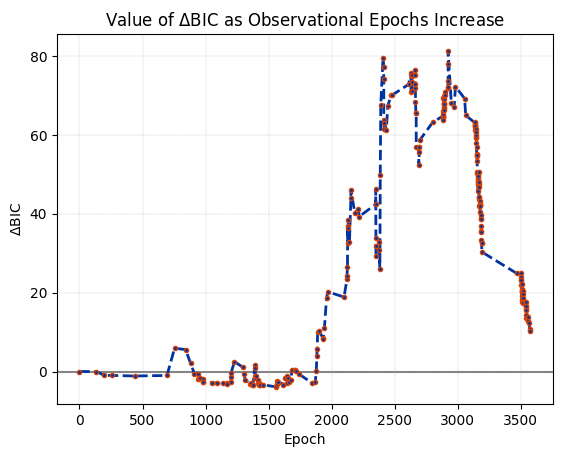

In [106]:
ephemeris_obj1.plot_running_delta_bic()

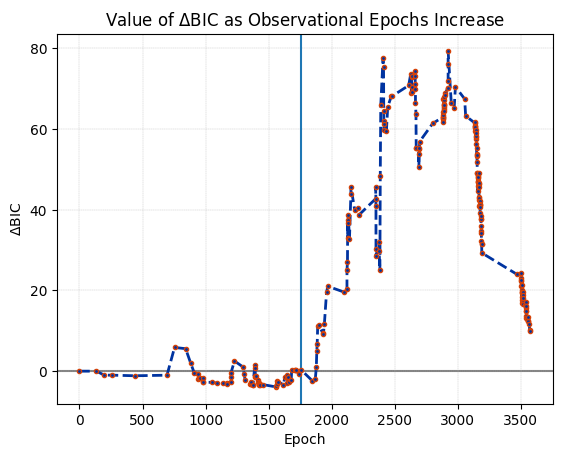

In [107]:
plt.axvline(new_occ_epoch)
ephemeris_obj2.plot_running_delta_bic()

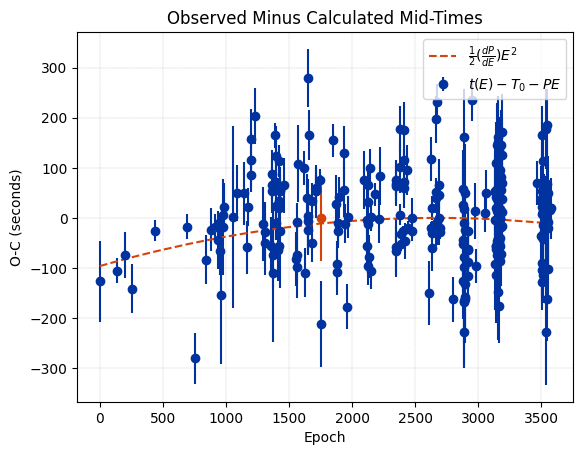

In [108]:
lin_model = ephemeris_obj2.get_model_ephemeris("linear")
plt.errorbar([new_occ_epoch], [new_occ_time- lin_model["conjunction_time"] - (0.5*lin_model["period"]) - (lin_model["period"]*new_occ_epoch)], yerr=[0.001*86400], color="#D64309", marker="o")
ephemeris_obj2.plot_oc_plot()


## Testing with 10 Observed Occultations over the years of 2015 - 2023

Generating 10 random occultations between Jan 1st, 2015 and Jan 1st, 2024

In [138]:
ten_new_occs = get_n_random_observations(10, "occ", "2015-1-1 0:00", "2024-1-1 0:00", tres_5b, tres_5b_skycoord, boise_state_earthlocation, ephemeris_obj1.timing_data.mid_times[0], 1.482246865)

/var/folders/6v/mhhfytp907b8qxnfk7r3rw4c0000gn/T/ipykernel_16787/73998559.py:26: FutureWarning: Setting the location attribute post initialization will be disallowed in a future version of Astropy. Instead you should set the location when creating the Time object. In the future, this will raise an AttributeError.
  time_obj.location = location_obj
/var/folders/6v/mhhfytp907b8qxnfk7r3rw4c0000gn/T/ipykernel_16787/73998559.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(N)


In [140]:
# Insert new data into the existing data arrays and create new timing and ephemeris object
new_epochs = np.append(epochs, ten_new_occs["new_epochs"])
new_mid_times = np.append(mid_times, ten_new_occs["new_mid_times"].value)
new_mid_time_errs = np.append(mid_time_errs, ten_new_occs["new_mid_time_errs"])
new_tra_or_occ = np.append(tra_or_occ, ten_new_occs["new_tra_or_occ"])

In [143]:
ten_new_occs_mid_times_iso = ten_new_occs["new_mid_times"].copy()
ten_new_occs_mid_times_iso.format = "iso"
print("Occultation Mid-Times Being Added:")
print(ten_new_occs_mid_times_iso.value)

Occultation Mid-Times Being Added:
['2016-03-18 06:40:34.431' '2022-08-17 17:03:03.595'
 '2021-11-16 11:52:29.705' '2017-04-19 12:29:16.039'
 '2019-06-18 13:23:22.869' '2019-01-18 08:50:57.697'
 '2020-11-12 09:58:03.550' '2022-02-06 00:26:26.807'
 '2015-11-05 21:01:22.808' '2015-04-04 22:48:15.084']


Creating the Timing Object and Ephemeris Objects 

In [116]:
timing_obj3 = TimingData('jd', new_epochs, new_mid_times, mid_time_uncertainties=new_mid_time_errs, tra_or_occ=new_tra_or_occ, time_scale='tdb')
ephemeris_obj3 = Ephemeris(timing_obj3)

Generate Plots

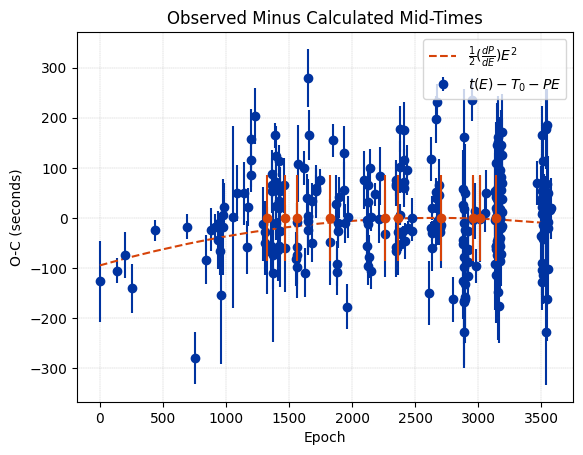

In [161]:
lin_model_3 = ephemeris_obj3.get_model_ephemeris("linear")
meep = (ten_new_occs["new_mid_times"].value - lin_model_3["conjunction_time"] - (0.5*lin_model_3["period"]) - (lin_model_3["period"]*np.array(ten_new_occs["new_epochs"])))
plt.errorbar(ten_new_occs["new_epochs"], meep, yerr=ten_new_occs["new_mid_time_errs"]*86400, color="#D64309", marker="o", linestyle='none', zorder=10)
ephemeris_obj3.plot_oc_plot()

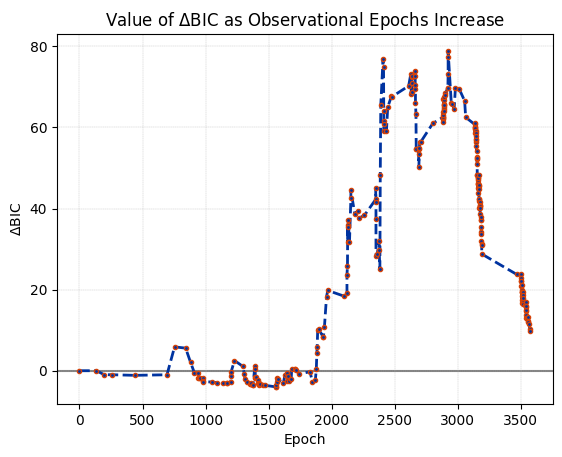

In [162]:
ephemeris_obj3.plot_running_delta_bic()